# MCT4001 Scientific Computing in Python Session 11
![mct-banner](https://raw.githubusercontent.com/wiki/MCT-master/Guides/assets/img/mct-banner.jpg)

In [1]:
# importing packages

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import sounddevice as sd
import librosa
import librosa.display
import math
import scipy
import time

#importing signal processing package from scipy (if not we have to specify scipy.signal)
from scipy import signal


# defining funtions that will be used in this notebook

def myAddSineSynth(freqs, dur_ms, amps=1, phas=0, sr=48000):
    
    t = np.arange(0,dur_ms/1000,1/sr)
    s = np.zeros(t.shape)

    if amps == 1:
        amps = np.ones(len(freqs))
        
    if phas == 0:
        phas = np.zeros(len(freqs))
    
    for f,a,p in zip(freqs,amps,phas):
            s = s + a*np.sin(2*np.pi*f*t+p)
        
    return s

def myPlotStem(signal,title):
    plt.figure(figsize=(10, 2))
    plt.stem(signal, use_line_collection=True)
    plt.grid(True)
    plt.xticks(range(0,signal.size))
    plt.title(title)
    plt.show()

def myPlotLineSmp(signal,title):
    plt.figure(figsize=(10, 2))
    plt.plot(signal)
    plt.grid(True)
    plt.title(title)
    plt.show()
    
def myPlotLineTime(signal,sr,title):
    time = np.arange(0,signal.size/sr,1/sr)
    time = time[0:signal.size]
    plt.figure(figsize=(10, 2))
    plt.plot(time,signal)
    plt.grid(True)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()
    
def mySpectrogram(s,sr,title):
    D = librosa.stft(s)
    DdB = librosa.amplitude_to_db(abs(D))
    plt.figure(figsize=(10, 2))
    librosa.display.specshow(DdB, sr=sr, x_axis='time', y_axis='hz')
    plt.title(title)
    plt.show()

def myWaveform(s,sr,title):
    plt.figure(figsize=(10, 2))
    librosa.display.waveshow(s, sr=sr)
    plt.title(title)
    plt.show()
    
def mySpectrum(s,sr,title):
    f, psd = signal.periodogram(s, sr)
    plt.figure(figsize=(7, 2))
    plt.semilogy(f, psd)
    #plt.ylim([1e-7, 1e2])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('Power Spectral Density')
    plt.show()
    
def myFiltResponse(b,a,sr,amp_range,title):
    w, h = scipy.signal.freqz(b,a)
    fig, ax1 = plt.subplots()
    ax1.set_title(title)
    ax1.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')
    if amp_range < 0:
        raise ValueError('amp_range must be positive')
    if amp_range != 0:
        plt.ylim(-amp_range, amp_range) # adjusting the range of amplitude vertical axis
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Normalized Frequency')
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w/math.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.grid()
    ax2.axis('tight')
    plt.show()



In [2]:
%config IPCompleter.greedy=True
%matplotlib inline

## 1. Deconvolution

The deconvolution (as the name suggests) is the inverse operation of the convolution. Given a system response and the output of an LTI, it allows to compute the original input signal. The computation in the time domain is fairly complex and long (via time-domain polynomial long division), while in the frequency domain is as a simple division (opposite as the convolution which is a multiplication). In theory the deconvolution allows to "remove" a FIR  filter (as an EQ, reverb, etc..) from a signal. In pure digital computer simulations (or if you are just looping back the audio from a soundcard), this works very well. In reality this does not work well because within the system we model as an LTI there are wlways have minor nonlinearities, noise sources (always present in speakers, mics, and other electronics) and unknown components (room acoustic).

In [3]:
# Loading input and impulse response

sr=48000

x, sr = librosa.load('./files/Loop.wav', sr=sr)
h, sr = librosa.load('./files/IR_flanger_space.wav', sr=sr)


In [4]:
#  time domain convolution and deconvolution

# time domain convolution
y = signal.convolve(x,h)

# time domein deconvolution
# computationally inefficient
# works well only on signals/responses with handful of samples
# based on polynomial long division

x_recovered_t,_ =  signal.deconvolve(y,h)


In [5]:
# frequency domain convolution and deconvolution

# zero padding h to match x
h = np.pad(h,[0,x.size-h.size])

# transform to frequency domain
X = scipy.fft.fft(x)
H = scipy.fft.fft(h)

# applying filter (product in freq domain is equivalent of convolution)
Y = X*H

# back to time domain
y = np.real(scipy.fft.ifft(Y))

# the deconvolution in the frequency domain is the division between dignal and DFT

# back again in the frequency domain
Y = scipy.fft.fft(y)

# removing filter (division in frequency domain is the deconvolution)
X_recovered_f = Y/H

# finally back to time domain with the recovered signal
x_recovered_f = np.real(scipy.fft.ifft(X_recovered_f))


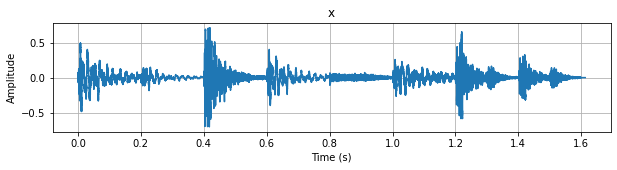

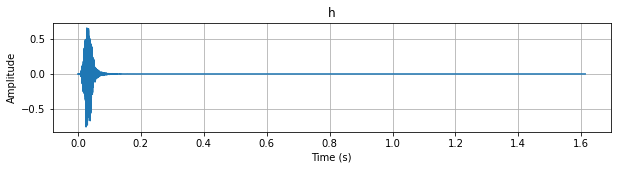

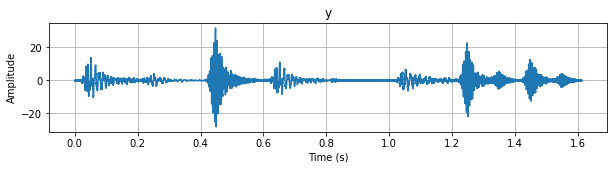

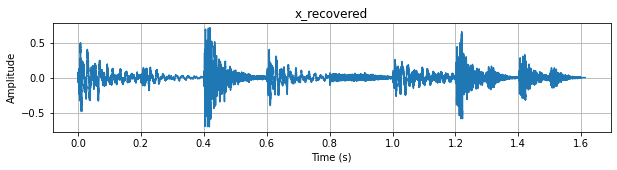

In [6]:
myPlotLineTime(x,sr,'x')
myPlotLineTime(h,sr,'h')
myPlotLineTime(y,sr,'y')
myPlotLineTime(x_recovered_f,sr,'x_recovered')

sd.play(x,sr)
sd.wait()
sd.play(h,sr)
sd.wait()
sd.play(y/np.max(y),sr)  # normalizing before playback, output of convolution may exceed +/- 1
sd.wait()
sd.play(x_recovered_f/np.max(x_recovered_f),sr)


#### Task 1


Experiment with the time-domain and frequency-domain deconvolution using the various impulse responses included in the folder "files" (filename start with IR_) and see if deconvolution is always possible (and/or use other impulse responses you may have). Use the "time" package to measure execution time of the deconvolution in time and frequency domain.

## 2. Room Compensation

The principle is the same as 1. but in this case we use the deconvolution (computed in the frequency domain) to "recover" for a poorly sounding environment (ideally this will return a flat response). First we simulate a room response by convolution, then we compensate taking advantage of the measured room impulse response.

In [7]:
#  loading and creating signals
sr = 48000

music, sr = librosa.load('./files/Loop.wav', sr=sr)
noise = np.random.normal(0, 0.1, 2*sr) 


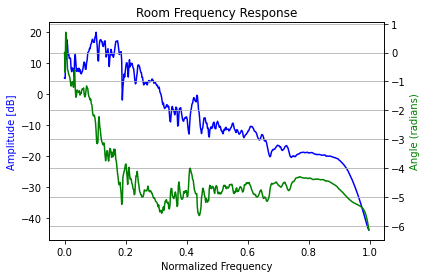

In [8]:
# loading and displaying the response

response, sr = librosa.load('./files/IR__tosha73__ir-brown-cab-audix-i5-center.wav', sr=sr)
#response, sr = librosa.load('./files/IR_jamespeacock4616__car.wav', sr)

myFiltResponse(response,1,sr,0,'Room Frequency Response')

In [9]:
# simulating what the actual music and noise would sound in the room
music_room = signal.lfilter(response,1,music) #equivalent of signal.convolve(music,response)
noise_room = signal.lfilter(response,1,noise) #equivalent of signal.convolve(noise,response)

sd.play(music,sr)
sd.wait()
sd.play(music_room/np.max(music_room),sr)  # normalizing before playback, output of convolution may exceed +/- 1
sd.wait()
sd.play(noise,sr)
sd.wait()
sd.play(noise_room/np.max(music_room),sr)  # normalizing before playback, output of convolution may exceed +/- 1
sd.wait()

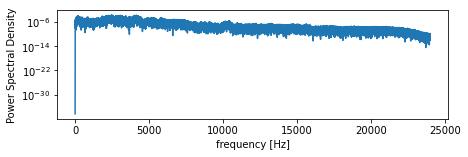

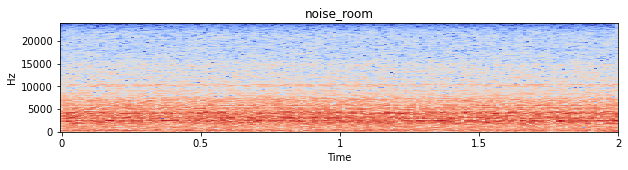

In [10]:
# displaying the noise filtered by the room response
mySpectrum(noise_room,sr,'noise_room')
mySpectrogram(noise_room,sr,'noise_room')

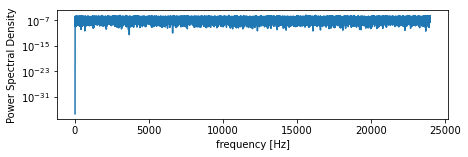

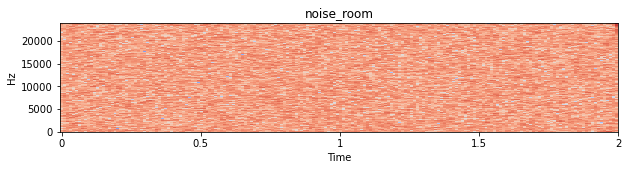

In [11]:
# compensation for room response

# zero padding
response_padded = np.pad(response,[0,noise_room.size-response.size])

# transform to frequency domain
Noise_Room = scipy.fft.fft(noise_room)
Response = scipy.fft.fft(response_padded)

# applying deconvolution (aka inverted room response)
Noise_Room_Compensated = Noise_Room/Response

# back to time domain
noise_room_compensated = np.real(scipy.fft.ifft(Noise_Room_Compensated))

# displaying the noise filtered by the room response
mySpectrum(noise_room_compensated,sr,'noise_room')
mySpectrogram(noise_room_compensated,sr,'noise_room')

sd.play(noise_room_compensated,sr)
sd.wait()


In [12]:
# compensation for room response

# zero padding
response_padded = np.pad(response,[0,music_room.size-response.size])

# transform to frequency domain
Music_Room = scipy.fft.fft(music_room)
Response = scipy.fft.fft(response_padded)


# applying deconvolution (aka inverted room response)
Music_Room_Compensated = Music_Room/Response

# back to time domain
music_room_compensated = np.real(scipy.fft.ifft(Music_Room_Compensated))

sd.play(music_room_compensated,sr)
sd.wait()


#### Task 2

Reflect on the computational approach used for the room compensation in the above example and think about context/applications in which this may work well, and in which this may not work. Share your findings with the rest of the class.

## 3. Short-time Fourier transform

In scipy signnal there are functions to compute the [STFT](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html) and [ISTFT](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.istft.html). These present a large set of innput paramaters that allows to customize the computation. 


The short time fourier transform is computed over short overlapping segments (windows) of a long signal. Windows size, overlap, type of window and other key parameters can be specified.

Here you find a list of available [window functions](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.get_window.html#scipy.signal.get_window).

If you manually specify the overlap and need to reconstruct the time domain signal, check that the values are correct using [this function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.check_COLA.html#scipy.signal.check_COLA).

In [13]:
# Computing STFT

sr=48000

x, sr = librosa.load('./files/Loop.wav', sr)

window_type='hann'
window_size=2048
window_overlap=1024
fft_size=None
onesided=False #false for processing, can set to true for analysis (e.g. spectrogram)

f, t, Zxx = signal.stft(x, fs=sr, window=window_type, nperseg=window_size, noverlap=window_overlap, nfft=fft_size, return_onesided=onesided)

print(x.shape)
print(f.shape)
print(t.shape)
print(Zxx.shape)


(77400,)
(2048,)
(77,)
(2048, 77)


/var/folders/by/m4c7_99d74j70dpnkg3np2r80000gq/T/ipykernel_56150/638963463.py:5: FutureWarning: Pass sr=48000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  x, sr = librosa.load('./files/Loop.wav', sr)


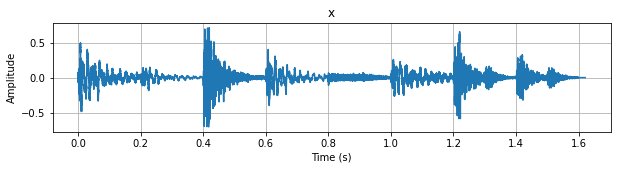

In [14]:
# inverting STFT

# the signal can be dusscefully reconstructed only if we satisfy the
# requirements of the Constant OverLap Add (COLA) 
if signal.check_COLA(window=window_type, nperseg=window_size, noverlap=window_overlap):
    _, x_reconstructed = np.real(signal.istft(Zxx, fs=sr, window=window_type, nperseg=window_size, noverlap=window_overlap, input_onesided=onesided))
   
myPlotLineTime(x_reconstructed,sr,'x')
    
sd.play(x_reconstructed,sr)
sd.wait()


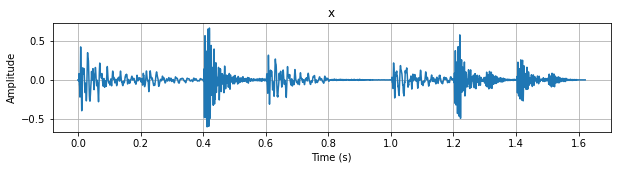

In [15]:
# STFT processing

sr=48000
x, sr = librosa.load('./files/Loop.wav', sr=sr)

# 1. designing filter

numtaps = 77
fc = 500
filt = signal.firwin(numtaps, fc, fs=sr, pass_zero=True)

# 2. computing STFT

window_type='hann'
window_size=2048
window_overlap=1024
fft_size=None
onesided=False

_, _, Zxx = signal.stft(x, fs=sr, window=window_type, nperseg=window_size, noverlap=window_overlap, return_onesided=onesided)


# 3. padding the filter to match winsize and computing its DFT

filt_pad = np.pad(filt,[0,window_size-filt.size])

FILT_pad = scipy.fft.fft(filt_pad)

# 4. applying the filter for each window (in-place computation, overwriting Zxx)

for col_idx in range(Zxx.shape[1]):
    Zxx[:,col_idx] = Zxx[:,col_idx]*FILT_pad

# computing ISTFT
if signal.check_COLA(window=window_type, nperseg=window_size, noverlap=window_overlap):
    _, x_filtered = np.real(signal.istft(Zxx, fs=sr, window=window_type, nperseg=window_size, noverlap=window_overlap, input_onesided=onesided))
    

myPlotLineTime(x_filtered,sr,'x')
    
sd.play(x_filtered,sr)
sd.wait()


## 4. Spectrogram

The spectrogram is a useful time-frequency representation of signals. It allows to have relatively high resolution in both time and frequancy. When analysing a relatively long signal (the concept of long may vary depending on the context) computing the spectrum of the overall signal is poorly significant.

The spectrogram is simply the visualization of the STFT  (positive frequencies only). Values are color coded and some axis rearrangement is necessary.


![block processing](https://eng.libretexts.org/@api/deki/files/1666/sig20.png?revision=1&size=bestfit&width=550&height=353)

/var/folders/by/m4c7_99d74j70dpnkg3np2r80000gq/T/ipykernel_56150/1499232667.py:4: FutureWarning: Pass sr=48000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  x, sr = librosa.load('./files/Loop.wav', sr)


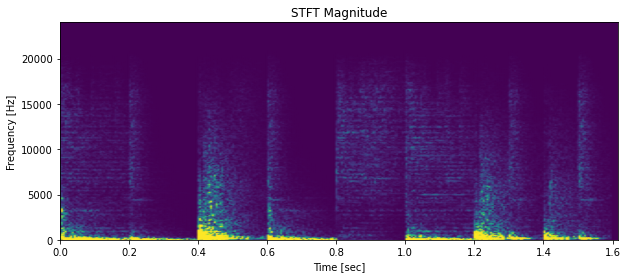

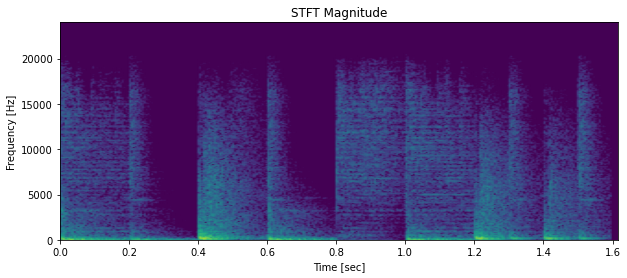

In [16]:
# computing STFT

sr=48000
x, sr = librosa.load('./files/Loop.wav', sr)

window_type='hann'
window_size=512
window_overlap=256
fft_size=None
onesided=True

f, t, Zxx = signal.stft(x, fs=sr, window=window_type, nperseg=window_size, noverlap=window_overlap, return_onesided=onesided)

# linear magnitude
plt.figure(figsize=(10, 4))
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=0.01, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

# log magnitude
plt.figure(figsize=(10, 4))
plt.pcolormesh(t, f, 20*np.log10(np.abs(Zxx)), vmin=-80, vmax=0, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

## 5. Effect of windowing

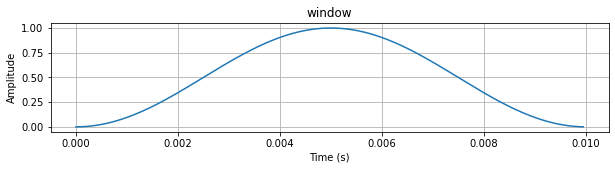

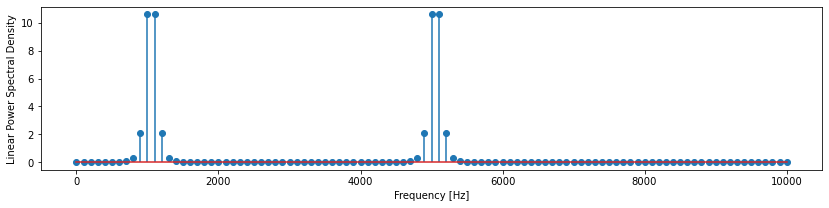

In [17]:
sr=20000

s = myAddSineSynth([1050,5050],10,amps=[0.25,0.25,0.25,0.25],sr=sr)


#change the window type to see how the resulting spectrum changes

#win = signal.get_window('boxcar', s.size)
win = signal.get_window('hann', s.size)
myPlotLineTime(win,sr,'window')

S = np.abs(scipy.fft.rfft(s*win))
f = np.linspace(0, sr/2, int(s.size/2) + 1)
plt.figure(figsize=(14, 3))
plt.stem(f, S)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Linear Power Spectral Density')
plt.show()
    
    


#### Task 3

Get familiar with the various parameters of the scipy.signal.stft and .istft, and find a set of parameters that do not satisfy the COLA constraints.

Try to use the STFT processing approach for the de-convolution.

Experiment with the computation and visualization of the spectrogram with different types of window and different values of window size and window overlap. Share your findings with the class.

## 6. Manual computation of STFT

In [18]:

sr=48000
x, sr = librosa.load('./files/Loop.wav', sr=sr)

window_size = 512 
window_overlap = 256
window_type='hann'

stride = window_size - window_overlap 
num_windows = int((x.size - window_size) / stride) + 1 
Zxx = np.empty([num_windows,window_size],dtype=complex)

for i in range(Zxx.shape[0]):
    # note that there no windowing is applied, if you want to apply a window, multiple the x segment before fft
    Zxx[i] = scipy.fft.fft(x[i*stride:i*stride+window_size])
    